# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

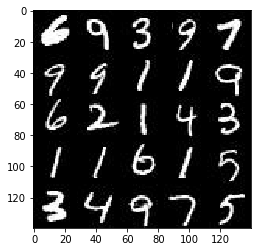

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

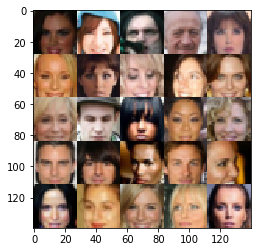

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32,(None,image_width, image_height, image_channels))
    z_inputs = tf.placeholder(tf.float32,(None,z_dim))
    lr = tf.placeholder(tf.float32,name='lr')

    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        h = tf.layers.conv2d(images, filters=32, kernel_size=5, strides=2,
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.maximum(0.2 * h, h)
        #h1 = tf.nn.relu(h1)
        
        h = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2,
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.maximum(0.2 * h, h)
        #h1 = tf.nn.relu(h1)
        
        h = tf.layers.conv2d(h, filters=128, kernel_size=5, strides=2,
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.maximum(0.2 * h, h)
        
        h = tf.layers.conv2d(h, filters=256, kernel_size=5, strides=2,
                              padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.maximum(0.2 * h, h)
        
        h = tf.reshape(h, [-1, 2*2*256])
        logits = tf.layers.dense(h, 1, activation=None)
        output = tf.sigmoid(logits)
    

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        h = tf.layers.dense(z, units=4*4*512)
        h = tf.reshape(h, (-1, 4, 4, 512))
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum( 0.2 * h, h)
        
        h = tf.layers.conv2d_transpose(h, filters=128, kernel_size=4, strides=1, padding='valid')
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(0.2 * h, h)
        
        h = tf.layers.conv2d_transpose(h, filters=64, kernel_size=5, strides=2, padding='same')
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(0.2 * h, h)
        
        h = tf.layers.conv2d_transpose(h, filters=32, kernel_size=5, strides=2, padding='same')
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(0.2 * h, h)
        
        logits = tf.layers.conv2d_transpose(h, filters=out_channel_dim, kernel_size=3, strides=1,
                                            padding='same')
        out = tf.tanh(logits)
        print(out.get_shape())
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

(?, 28, 28, 5)
(?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real,
                                                                           labels=tf.ones_like(disc_model_real)*(1-0.1)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                           labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                     labels=tf.ones_like(disc_model_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    gen_vars = [x for x in train_vars if x.name.startswith('generator')]
    disc_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=gen_vars)
    
    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, width, height, channels = data_shape
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    print(data_shape)
    
    i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(disc_opt, feed_dict={input_real: batch_images,
                                              input_z: batch_z,
                                              lr: learning_rate})
                sess.run(gen_opt, feed_dict={input_real: batch_images,
                                             input_z: batch_z,
                                             lr: learning_rate})
                
                i += 1
                if i % 10 == 0:
                    train_loss_disc = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_gen = gen_loss.eval({input_z: batch_z})
                    print('Epoch %d/%d Discriminator loss %.4f Generator loss %.4f' % (epoch_i+1,
                                                                                       epoch_count,
                                                                                       train_loss_disc,
                                                                                       train_loss_gen ))
                if i % 100 == 0:
                    show_generator_output(sess, 50, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 28, 28, 1)
(60000, 28, 28, 1)
Epoch 1/2 Discriminator loss 2.6253 Generator loss 1.0279
Epoch 1/2 Discriminator loss 0.4534 Generator loss 3.2827
Epoch 1/2 Discriminator loss 1.2228 Generator loss 5.9509
Epoch 1/2 Discriminator loss 1.4033 Generator loss 3.0161
Epoch 1/2 Discriminator loss 1.9521 Generator loss 4.7578
Epoch 1/2 Discriminator loss 1.2466 Generator loss 1.1931
Epoch 1/2 Discriminator loss 1.4304 Generator loss 0.5458
Epoch 1/2 Discriminator loss 1.2439 Generator loss 0.6280
Epoch 1/2 Discriminator loss 1.5562 Generator loss 0.4507
Epoch 1/2 Discriminator loss 1.3957 Generator loss 1.0085
(?, 28, 28, 1)


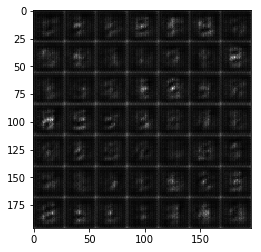

Epoch 1/2 Discriminator loss 1.4189 Generator loss 1.2585
Epoch 1/2 Discriminator loss 1.1608 Generator loss 0.9280
Epoch 1/2 Discriminator loss 1.3078 Generator loss 1.0084
Epoch 1/2 Discriminator loss 1.4834 Generator loss 1.2631
Epoch 1/2 Discriminator loss 1.3202 Generator loss 1.4049
Epoch 1/2 Discriminator loss 1.2572 Generator loss 0.9038
Epoch 1/2 Discriminator loss 1.2834 Generator loss 1.1049
Epoch 1/2 Discriminator loss 1.3611 Generator loss 1.2566
Epoch 1/2 Discriminator loss 1.2853 Generator loss 1.0432
Epoch 1/2 Discriminator loss 1.6319 Generator loss 1.5131
(?, 28, 28, 1)


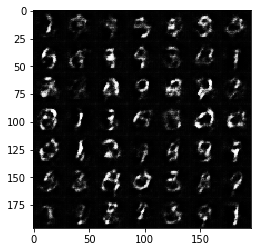

Epoch 1/2 Discriminator loss 1.2896 Generator loss 1.0152
Epoch 1/2 Discriminator loss 1.7360 Generator loss 1.7214
Epoch 1/2 Discriminator loss 1.2482 Generator loss 0.8100
Epoch 1/2 Discriminator loss 1.4478 Generator loss 0.4874
Epoch 1/2 Discriminator loss 1.4565 Generator loss 0.4862
Epoch 1/2 Discriminator loss 1.4749 Generator loss 0.4831
Epoch 1/2 Discriminator loss 1.2453 Generator loss 0.7161
Epoch 1/2 Discriminator loss 1.3117 Generator loss 0.6762
Epoch 1/2 Discriminator loss 1.3932 Generator loss 0.5603
Epoch 1/2 Discriminator loss 1.3636 Generator loss 0.6543
(?, 28, 28, 1)


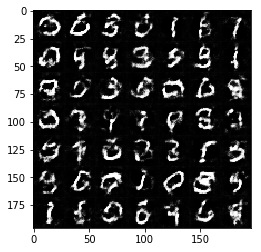

Epoch 1/2 Discriminator loss 1.3813 Generator loss 0.5833
Epoch 1/2 Discriminator loss 1.2471 Generator loss 0.7581
Epoch 1/2 Discriminator loss 1.3252 Generator loss 1.3223
Epoch 1/2 Discriminator loss 1.4119 Generator loss 1.1916
Epoch 1/2 Discriminator loss 1.2805 Generator loss 0.8953
Epoch 1/2 Discriminator loss 1.3268 Generator loss 1.2698
Epoch 1/2 Discriminator loss 1.2856 Generator loss 1.1278
Epoch 1/2 Discriminator loss 1.3356 Generator loss 1.0956
Epoch 1/2 Discriminator loss 1.3812 Generator loss 1.2109
Epoch 1/2 Discriminator loss 1.3286 Generator loss 1.2503
(?, 28, 28, 1)


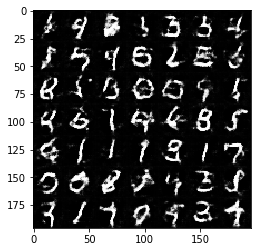

Epoch 1/2 Discriminator loss 1.2533 Generator loss 0.9996
Epoch 1/2 Discriminator loss 1.2415 Generator loss 0.9558
Epoch 1/2 Discriminator loss 1.3189 Generator loss 1.2037
Epoch 1/2 Discriminator loss 1.3619 Generator loss 1.2132
Epoch 1/2 Discriminator loss 1.3468 Generator loss 1.0096
Epoch 1/2 Discriminator loss 1.3111 Generator loss 0.8069
Epoch 1/2 Discriminator loss 1.4605 Generator loss 1.1424
Epoch 1/2 Discriminator loss 1.2141 Generator loss 0.8448
Epoch 1/2 Discriminator loss 1.2220 Generator loss 0.9505
Epoch 1/2 Discriminator loss 1.2722 Generator loss 1.2002
(?, 28, 28, 1)


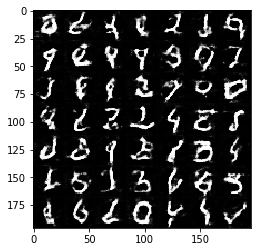

Epoch 1/2 Discriminator loss 1.3003 Generator loss 0.9507
Epoch 1/2 Discriminator loss 1.2292 Generator loss 0.8468
Epoch 1/2 Discriminator loss 1.2043 Generator loss 1.1255
Epoch 1/2 Discriminator loss 1.3377 Generator loss 1.1291
Epoch 1/2 Discriminator loss 1.3105 Generator loss 0.9999
Epoch 1/2 Discriminator loss 1.4524 Generator loss 1.4250
Epoch 1/2 Discriminator loss 1.2300 Generator loss 0.7127
Epoch 1/2 Discriminator loss 1.2130 Generator loss 0.8199
Epoch 1/2 Discriminator loss 1.2244 Generator loss 0.7204
Epoch 1/2 Discriminator loss 1.2506 Generator loss 0.7512
(?, 28, 28, 1)


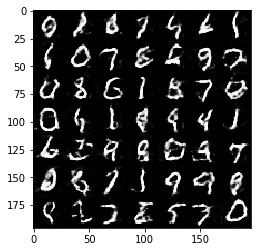

Epoch 1/2 Discriminator loss 1.1387 Generator loss 1.0008
Epoch 1/2 Discriminator loss 1.5607 Generator loss 0.4323
Epoch 1/2 Discriminator loss 1.2445 Generator loss 0.7714
Epoch 1/2 Discriminator loss 1.2737 Generator loss 1.0508
Epoch 1/2 Discriminator loss 1.5526 Generator loss 1.7249
Epoch 1/2 Discriminator loss 1.3040 Generator loss 1.0232
Epoch 1/2 Discriminator loss 1.6423 Generator loss 0.3754
Epoch 1/2 Discriminator loss 1.3043 Generator loss 0.6582
Epoch 1/2 Discriminator loss 1.5583 Generator loss 0.4406
Epoch 1/2 Discriminator loss 1.1850 Generator loss 0.9614
(?, 28, 28, 1)


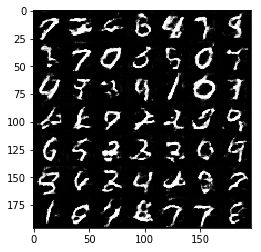

Epoch 1/2 Discriminator loss 1.1928 Generator loss 1.1016
Epoch 1/2 Discriminator loss 1.4259 Generator loss 1.3856
Epoch 1/2 Discriminator loss 1.2277 Generator loss 0.7049
Epoch 1/2 Discriminator loss 1.2516 Generator loss 0.7387
Epoch 1/2 Discriminator loss 1.4489 Generator loss 0.5300
Epoch 1/2 Discriminator loss 1.2197 Generator loss 0.7635
Epoch 1/2 Discriminator loss 1.1705 Generator loss 0.8148
Epoch 1/2 Discriminator loss 1.3921 Generator loss 0.5891
Epoch 1/2 Discriminator loss 1.3265 Generator loss 0.6798
Epoch 1/2 Discriminator loss 1.2912 Generator loss 0.6016
(?, 28, 28, 1)


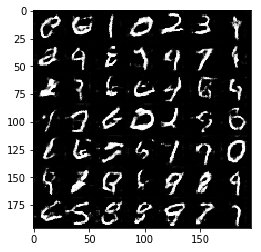

Epoch 1/2 Discriminator loss 1.3770 Generator loss 0.5650
Epoch 1/2 Discriminator loss 1.1042 Generator loss 0.9387
Epoch 1/2 Discriminator loss 1.2793 Generator loss 0.7327
Epoch 1/2 Discriminator loss 1.3004 Generator loss 0.6254
Epoch 1/2 Discriminator loss 1.0754 Generator loss 1.1250
Epoch 1/2 Discriminator loss 2.0681 Generator loss 1.8555
Epoch 1/2 Discriminator loss 1.1782 Generator loss 0.8572
Epoch 1/2 Discriminator loss 1.1719 Generator loss 0.8571
Epoch 1/2 Discriminator loss 1.2635 Generator loss 0.7423
Epoch 1/2 Discriminator loss 1.2033 Generator loss 0.8709
(?, 28, 28, 1)


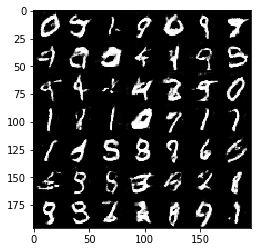

Epoch 1/2 Discriminator loss 1.1685 Generator loss 0.9327
Epoch 1/2 Discriminator loss 1.2509 Generator loss 1.1397
Epoch 1/2 Discriminator loss 1.0464 Generator loss 1.1859
Epoch 2/2 Discriminator loss 1.1328 Generator loss 1.2577
Epoch 2/2 Discriminator loss 1.2965 Generator loss 1.6225
Epoch 2/2 Discriminator loss 1.1458 Generator loss 0.8243
Epoch 2/2 Discriminator loss 1.2181 Generator loss 0.8116
Epoch 2/2 Discriminator loss 1.2854 Generator loss 1.3958
Epoch 2/2 Discriminator loss 1.0753 Generator loss 1.0837
Epoch 2/2 Discriminator loss 1.2312 Generator loss 0.7167
(?, 28, 28, 1)


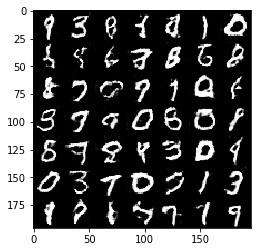

Epoch 2/2 Discriminator loss 1.3595 Generator loss 0.5504
Epoch 2/2 Discriminator loss 1.1524 Generator loss 0.8212
Epoch 2/2 Discriminator loss 1.1801 Generator loss 1.2116
Epoch 2/2 Discriminator loss 1.0402 Generator loss 1.0820
Epoch 2/2 Discriminator loss 1.1046 Generator loss 1.0932
Epoch 2/2 Discriminator loss 1.4316 Generator loss 2.0001
Epoch 2/2 Discriminator loss 1.2885 Generator loss 0.8146
Epoch 2/2 Discriminator loss 1.1776 Generator loss 1.0319
Epoch 2/2 Discriminator loss 1.1104 Generator loss 1.1047
Epoch 2/2 Discriminator loss 1.1223 Generator loss 1.0280
(?, 28, 28, 1)


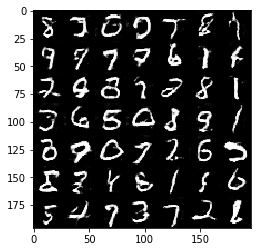

Epoch 2/2 Discriminator loss 1.0647 Generator loss 1.3136
Epoch 2/2 Discriminator loss 1.2466 Generator loss 0.7525
Epoch 2/2 Discriminator loss 1.2485 Generator loss 0.6278
Epoch 2/2 Discriminator loss 1.3749 Generator loss 0.5527
Epoch 2/2 Discriminator loss 1.1574 Generator loss 0.8233
Epoch 2/2 Discriminator loss 1.1898 Generator loss 0.8759
Epoch 2/2 Discriminator loss 2.3116 Generator loss 2.0233
Epoch 2/2 Discriminator loss 1.1735 Generator loss 0.7544
Epoch 2/2 Discriminator loss 1.1632 Generator loss 0.8342
Epoch 2/2 Discriminator loss 1.1021 Generator loss 1.0129
(?, 28, 28, 1)


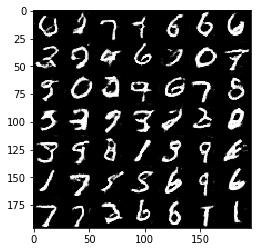

Epoch 2/2 Discriminator loss 1.1989 Generator loss 0.7436
Epoch 2/2 Discriminator loss 1.2606 Generator loss 0.7716
Epoch 2/2 Discriminator loss 1.0593 Generator loss 1.2453
Epoch 2/2 Discriminator loss 1.0684 Generator loss 1.0617
Epoch 2/2 Discriminator loss 1.3486 Generator loss 0.5243
Epoch 2/2 Discriminator loss 1.2856 Generator loss 0.5988
Epoch 2/2 Discriminator loss 1.0938 Generator loss 1.0236
Epoch 2/2 Discriminator loss 1.4361 Generator loss 1.6720
Epoch 2/2 Discriminator loss 1.0033 Generator loss 1.3189
Epoch 2/2 Discriminator loss 1.1295 Generator loss 1.3677
(?, 28, 28, 1)


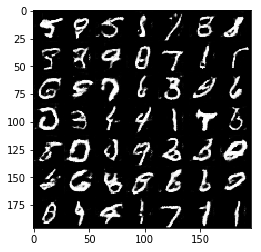

Epoch 2/2 Discriminator loss 1.2927 Generator loss 1.3798
Epoch 2/2 Discriminator loss 0.9853 Generator loss 1.1448
Epoch 2/2 Discriminator loss 1.2785 Generator loss 1.2464
Epoch 2/2 Discriminator loss 2.0228 Generator loss 2.2136
Epoch 2/2 Discriminator loss 1.1033 Generator loss 0.8484
Epoch 2/2 Discriminator loss 1.1232 Generator loss 0.7882
Epoch 2/2 Discriminator loss 1.1207 Generator loss 0.7825
Epoch 2/2 Discriminator loss 1.5074 Generator loss 0.4659
Epoch 2/2 Discriminator loss 1.0482 Generator loss 0.8866
Epoch 2/2 Discriminator loss 1.3407 Generator loss 1.5830
(?, 28, 28, 1)


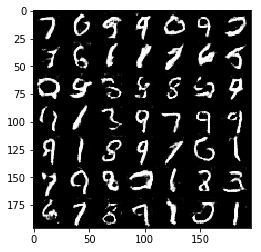

Epoch 2/2 Discriminator loss 1.0884 Generator loss 1.1151
Epoch 2/2 Discriminator loss 1.1200 Generator loss 1.9056
Epoch 2/2 Discriminator loss 1.1327 Generator loss 0.7733
Epoch 2/2 Discriminator loss 1.2744 Generator loss 0.5874
Epoch 2/2 Discriminator loss 1.1584 Generator loss 0.8170
Epoch 2/2 Discriminator loss 1.3208 Generator loss 0.6000
Epoch 2/2 Discriminator loss 1.2653 Generator loss 0.5944
Epoch 2/2 Discriminator loss 1.0564 Generator loss 0.7964
Epoch 2/2 Discriminator loss 1.3235 Generator loss 0.5181
Epoch 2/2 Discriminator loss 1.2748 Generator loss 0.5752
(?, 28, 28, 1)


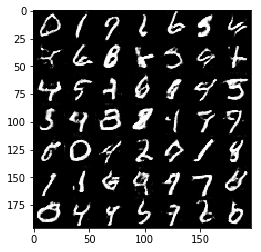

Epoch 2/2 Discriminator loss 1.0348 Generator loss 0.9661
Epoch 2/2 Discriminator loss 1.3611 Generator loss 1.6427
Epoch 2/2 Discriminator loss 0.9488 Generator loss 1.0915
Epoch 2/2 Discriminator loss 1.2076 Generator loss 0.8154
Epoch 2/2 Discriminator loss 1.2201 Generator loss 1.1278
Epoch 2/2 Discriminator loss 0.9377 Generator loss 1.2868
Epoch 2/2 Discriminator loss 1.0897 Generator loss 0.7760
Epoch 2/2 Discriminator loss 1.0584 Generator loss 0.8452
Epoch 2/2 Discriminator loss 1.2414 Generator loss 0.6342
Epoch 2/2 Discriminator loss 1.0107 Generator loss 1.1744
(?, 28, 28, 1)


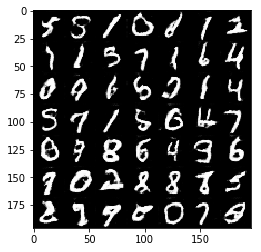

Epoch 2/2 Discriminator loss 1.5403 Generator loss 0.4651
Epoch 2/2 Discriminator loss 1.0061 Generator loss 0.9467
Epoch 2/2 Discriminator loss 1.3439 Generator loss 1.1221
Epoch 2/2 Discriminator loss 0.9049 Generator loss 1.2006
Epoch 2/2 Discriminator loss 1.0901 Generator loss 1.0632
Epoch 2/2 Discriminator loss 1.2386 Generator loss 1.3930
Epoch 2/2 Discriminator loss 1.0724 Generator loss 1.7166
Epoch 2/2 Discriminator loss 1.1529 Generator loss 1.1200
Epoch 2/2 Discriminator loss 1.0060 Generator loss 1.3846
Epoch 2/2 Discriminator loss 1.1346 Generator loss 0.8713
(?, 28, 28, 1)


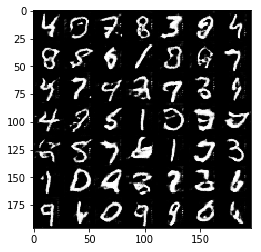

Epoch 2/2 Discriminator loss 1.4477 Generator loss 1.8800
Epoch 2/2 Discriminator loss 0.9361 Generator loss 1.0794
Epoch 2/2 Discriminator loss 1.4510 Generator loss 1.8773
Epoch 2/2 Discriminator loss 1.0582 Generator loss 0.8512
Epoch 2/2 Discriminator loss 1.3744 Generator loss 1.7209
Epoch 2/2 Discriminator loss 0.9943 Generator loss 0.9339
Epoch 2/2 Discriminator loss 0.9822 Generator loss 1.4577
Epoch 2/2 Discriminator loss 1.0228 Generator loss 1.2212
Epoch 2/2 Discriminator loss 1.4220 Generator loss 0.4674
Epoch 2/2 Discriminator loss 1.0288 Generator loss 0.8103
(?, 28, 28, 1)


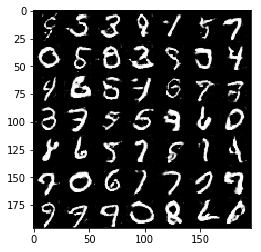

Epoch 2/2 Discriminator loss 1.7398 Generator loss 1.6859
Epoch 2/2 Discriminator loss 0.9972 Generator loss 0.9628
Epoch 2/2 Discriminator loss 0.8839 Generator loss 1.4060
Epoch 2/2 Discriminator loss 1.3260 Generator loss 1.6263
Epoch 2/2 Discriminator loss 1.0980 Generator loss 0.9018
Epoch 2/2 Discriminator loss 1.0668 Generator loss 1.1298
Epoch 2/2 Discriminator loss 1.9720 Generator loss 0.2490


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 28, 28, 3)
(202599, 28, 28, 3)
Epoch 1/1 Discriminator loss 1.8139 Generator loss 6.3810
Epoch 1/1 Discriminator loss 1.8990 Generator loss 5.2241
Epoch 1/1 Discriminator loss 1.2540 Generator loss 0.9163
Epoch 1/1 Discriminator loss 0.8170 Generator loss 1.5775
Epoch 1/1 Discriminator loss 1.3396 Generator loss 2.4348
Epoch 1/1 Discriminator loss 1.1947 Generator loss 1.7221
Epoch 1/1 Discriminator loss 1.0249 Generator loss 1.6376
Epoch 1/1 Discriminator loss 1.1974 Generator loss 1.5894
Epoch 1/1 Discriminator loss 1.3245 Generator loss 2.2107
Epoch 1/1 Discriminator loss 1.1105 Generator loss 1.9790
(?, 28, 28, 3)


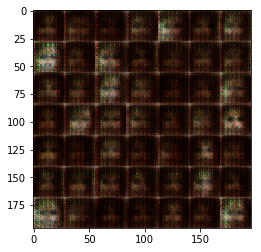

Epoch 1/1 Discriminator loss 0.9399 Generator loss 1.1766
Epoch 1/1 Discriminator loss 1.0395 Generator loss 1.5338
Epoch 1/1 Discriminator loss 1.0153 Generator loss 1.2854
Epoch 1/1 Discriminator loss 1.5813 Generator loss 1.6271
Epoch 1/1 Discriminator loss 0.9665 Generator loss 1.7138
Epoch 1/1 Discriminator loss 1.0645 Generator loss 1.5878
Epoch 1/1 Discriminator loss 1.3608 Generator loss 1.7244
Epoch 1/1 Discriminator loss 1.2290 Generator loss 1.3919
Epoch 1/1 Discriminator loss 1.0918 Generator loss 1.2620
Epoch 1/1 Discriminator loss 1.7344 Generator loss 2.0429
(?, 28, 28, 3)


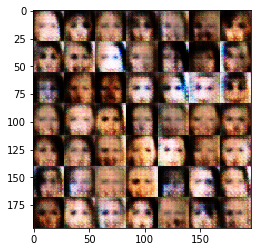

Epoch 1/1 Discriminator loss 1.5070 Generator loss 1.4070
Epoch 1/1 Discriminator loss 1.6148 Generator loss 1.4174
Epoch 1/1 Discriminator loss 1.4151 Generator loss 1.1902
Epoch 1/1 Discriminator loss 1.4833 Generator loss 1.2316
Epoch 1/1 Discriminator loss 1.1447 Generator loss 1.3471
Epoch 1/1 Discriminator loss 1.3741 Generator loss 1.2319
Epoch 1/1 Discriminator loss 1.0542 Generator loss 1.2137
Epoch 1/1 Discriminator loss 1.4261 Generator loss 1.2600
Epoch 1/1 Discriminator loss 1.2860 Generator loss 0.7018
Epoch 1/1 Discriminator loss 1.2386 Generator loss 0.7314
(?, 28, 28, 3)


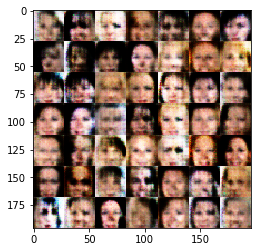

Epoch 1/1 Discriminator loss 1.3327 Generator loss 0.5781
Epoch 1/1 Discriminator loss 1.1633 Generator loss 0.8915
Epoch 1/1 Discriminator loss 1.9778 Generator loss 2.1450
Epoch 1/1 Discriminator loss 1.2856 Generator loss 0.6408
Epoch 1/1 Discriminator loss 1.3604 Generator loss 0.5506
Epoch 1/1 Discriminator loss 1.4044 Generator loss 0.4926
Epoch 1/1 Discriminator loss 0.9842 Generator loss 1.1355
Epoch 1/1 Discriminator loss 1.6324 Generator loss 0.3979
Epoch 1/1 Discriminator loss 1.1494 Generator loss 0.8230
Epoch 1/1 Discriminator loss 1.4033 Generator loss 0.5291
(?, 28, 28, 3)


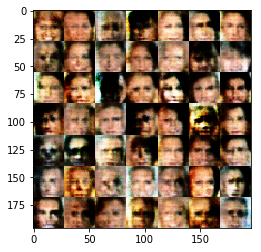

Epoch 1/1 Discriminator loss 1.4660 Generator loss 0.4966
Epoch 1/1 Discriminator loss 1.1879 Generator loss 0.7608
Epoch 1/1 Discriminator loss 1.6458 Generator loss 1.6271
Epoch 1/1 Discriminator loss 1.0250 Generator loss 1.4834
Epoch 1/1 Discriminator loss 1.1930 Generator loss 0.6646
Epoch 1/1 Discriminator loss 1.2444 Generator loss 0.7890
Epoch 1/1 Discriminator loss 1.2265 Generator loss 1.0411
Epoch 1/1 Discriminator loss 1.2686 Generator loss 1.2282
Epoch 1/1 Discriminator loss 1.4218 Generator loss 1.1939
Epoch 1/1 Discriminator loss 1.0722 Generator loss 1.1171
(?, 28, 28, 3)


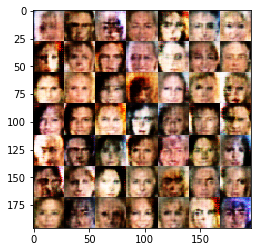

Epoch 1/1 Discriminator loss 1.2984 Generator loss 1.4100
Epoch 1/1 Discriminator loss 1.2883 Generator loss 0.7465
Epoch 1/1 Discriminator loss 1.4720 Generator loss 0.9350
Epoch 1/1 Discriminator loss 1.2445 Generator loss 0.8666
Epoch 1/1 Discriminator loss 1.2789 Generator loss 1.1910
Epoch 1/1 Discriminator loss 1.1893 Generator loss 0.9715
Epoch 1/1 Discriminator loss 1.1737 Generator loss 1.1136
Epoch 1/1 Discriminator loss 1.2402 Generator loss 0.9588
Epoch 1/1 Discriminator loss 1.2251 Generator loss 1.0536
Epoch 1/1 Discriminator loss 1.3178 Generator loss 0.9428
(?, 28, 28, 3)


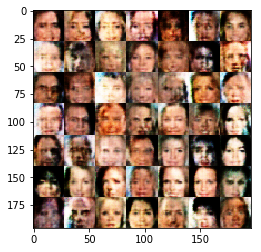

Epoch 1/1 Discriminator loss 1.1891 Generator loss 0.9194
Epoch 1/1 Discriminator loss 1.0778 Generator loss 1.2909
Epoch 1/1 Discriminator loss 1.3100 Generator loss 0.9329
Epoch 1/1 Discriminator loss 1.2766 Generator loss 0.8011
Epoch 1/1 Discriminator loss 1.4055 Generator loss 0.5226
Epoch 1/1 Discriminator loss 1.3081 Generator loss 0.6571
Epoch 1/1 Discriminator loss 1.1554 Generator loss 0.7914
Epoch 1/1 Discriminator loss 1.3191 Generator loss 0.6169
Epoch 1/1 Discriminator loss 1.3067 Generator loss 0.6452
Epoch 1/1 Discriminator loss 1.4240 Generator loss 0.4925
(?, 28, 28, 3)


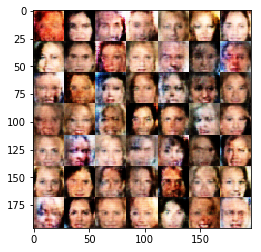

Epoch 1/1 Discriminator loss 1.3662 Generator loss 0.5436
Epoch 1/1 Discriminator loss 1.3124 Generator loss 0.6108
Epoch 1/1 Discriminator loss 1.1982 Generator loss 1.1911
Epoch 1/1 Discriminator loss 1.5437 Generator loss 0.7716
Epoch 1/1 Discriminator loss 1.3990 Generator loss 0.8303
Epoch 1/1 Discriminator loss 1.2709 Generator loss 0.8359
Epoch 1/1 Discriminator loss 1.0773 Generator loss 1.0316
Epoch 1/1 Discriminator loss 1.5158 Generator loss 1.5223
Epoch 1/1 Discriminator loss 1.2016 Generator loss 0.8341
Epoch 1/1 Discriminator loss 1.2660 Generator loss 0.9231
(?, 28, 28, 3)


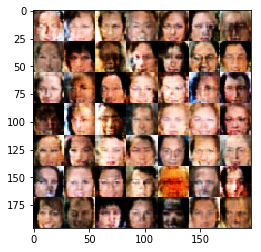

Epoch 1/1 Discriminator loss 1.6833 Generator loss 0.4124
Epoch 1/1 Discriminator loss 1.2475 Generator loss 0.9274
Epoch 1/1 Discriminator loss 1.1914 Generator loss 0.8975
Epoch 1/1 Discriminator loss 1.3106 Generator loss 0.6961
Epoch 1/1 Discriminator loss 1.3259 Generator loss 0.7527
Epoch 1/1 Discriminator loss 1.2733 Generator loss 0.6815
Epoch 1/1 Discriminator loss 1.3049 Generator loss 0.6681
Epoch 1/1 Discriminator loss 1.3143 Generator loss 0.7041
Epoch 1/1 Discriminator loss 1.3382 Generator loss 0.6533
Epoch 1/1 Discriminator loss 1.2684 Generator loss 0.7117
(?, 28, 28, 3)


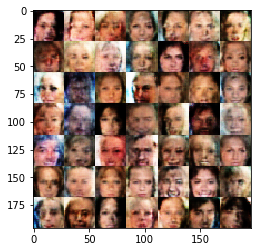

Epoch 1/1 Discriminator loss 1.3593 Generator loss 0.6134
Epoch 1/1 Discriminator loss 1.2077 Generator loss 0.9160
Epoch 1/1 Discriminator loss 1.2657 Generator loss 0.6724
Epoch 1/1 Discriminator loss 1.5794 Generator loss 0.3928
Epoch 1/1 Discriminator loss 1.1866 Generator loss 0.7915
Epoch 1/1 Discriminator loss 1.2150 Generator loss 0.8967
Epoch 1/1 Discriminator loss 1.3360 Generator loss 0.7152
Epoch 1/1 Discriminator loss 1.4161 Generator loss 0.5455
Epoch 1/1 Discriminator loss 1.4477 Generator loss 0.5080
Epoch 1/1 Discriminator loss 1.2575 Generator loss 0.6904
(?, 28, 28, 3)


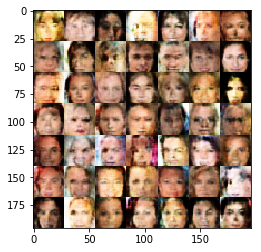

Epoch 1/1 Discriminator loss 1.2894 Generator loss 0.7072
Epoch 1/1 Discriminator loss 1.3432 Generator loss 0.7008
Epoch 1/1 Discriminator loss 1.2382 Generator loss 0.7635
Epoch 1/1 Discriminator loss 1.2415 Generator loss 1.1710
Epoch 1/1 Discriminator loss 1.3377 Generator loss 1.1362
Epoch 1/1 Discriminator loss 1.3435 Generator loss 0.9339
Epoch 1/1 Discriminator loss 1.2235 Generator loss 0.8802
Epoch 1/1 Discriminator loss 1.2509 Generator loss 1.1408
Epoch 1/1 Discriminator loss 1.3989 Generator loss 1.2228
Epoch 1/1 Discriminator loss 1.2638 Generator loss 0.8420
(?, 28, 28, 3)


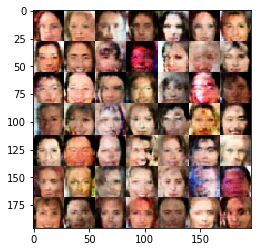

Epoch 1/1 Discriminator loss 1.3988 Generator loss 0.5888
Epoch 1/1 Discriminator loss 1.1806 Generator loss 0.8335
Epoch 1/1 Discriminator loss 1.3364 Generator loss 0.7496
Epoch 1/1 Discriminator loss 1.2534 Generator loss 0.7319
Epoch 1/1 Discriminator loss 1.3708 Generator loss 0.6298
Epoch 1/1 Discriminator loss 1.2270 Generator loss 0.8239
Epoch 1/1 Discriminator loss 1.1266 Generator loss 1.1632
Epoch 1/1 Discriminator loss 1.3771 Generator loss 1.1684
Epoch 1/1 Discriminator loss 1.2845 Generator loss 0.7271
Epoch 1/1 Discriminator loss 1.4054 Generator loss 0.5497
(?, 28, 28, 3)


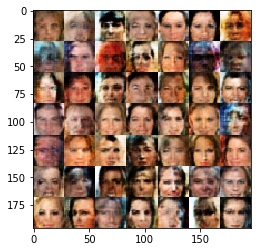

Epoch 1/1 Discriminator loss 1.3208 Generator loss 0.6415
Epoch 1/1 Discriminator loss 1.4065 Generator loss 0.5076
Epoch 1/1 Discriminator loss 1.2962 Generator loss 0.7518
Epoch 1/1 Discriminator loss 1.4065 Generator loss 0.5569
Epoch 1/1 Discriminator loss 1.4129 Generator loss 0.6738
Epoch 1/1 Discriminator loss 1.2965 Generator loss 0.8025
Epoch 1/1 Discriminator loss 1.5478 Generator loss 0.4203
Epoch 1/1 Discriminator loss 1.1814 Generator loss 0.9196
Epoch 1/1 Discriminator loss 1.3038 Generator loss 0.7903
Epoch 1/1 Discriminator loss 1.3814 Generator loss 0.5586
(?, 28, 28, 3)


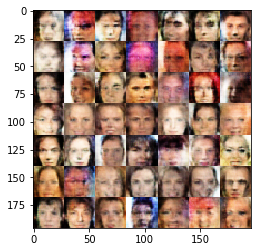

Epoch 1/1 Discriminator loss 1.4426 Generator loss 0.6102
Epoch 1/1 Discriminator loss 1.3594 Generator loss 0.8308
Epoch 1/1 Discriminator loss 1.3613 Generator loss 1.0421
Epoch 1/1 Discriminator loss 1.2694 Generator loss 0.9915
Epoch 1/1 Discriminator loss 1.4644 Generator loss 1.3439
Epoch 1/1 Discriminator loss 1.2998 Generator loss 0.8883
Epoch 1/1 Discriminator loss 1.3380 Generator loss 1.1242
Epoch 1/1 Discriminator loss 1.2986 Generator loss 0.7324
Epoch 1/1 Discriminator loss 1.3157 Generator loss 0.6829
Epoch 1/1 Discriminator loss 1.3972 Generator loss 0.5212
(?, 28, 28, 3)


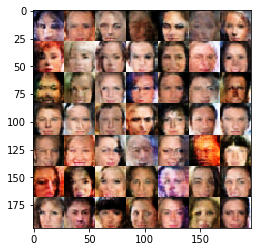

Epoch 1/1 Discriminator loss 1.1926 Generator loss 0.8468
Epoch 1/1 Discriminator loss 1.3765 Generator loss 0.5429
Epoch 1/1 Discriminator loss 1.3610 Generator loss 0.6237
Epoch 1/1 Discriminator loss 1.4410 Generator loss 0.5260
Epoch 1/1 Discriminator loss 1.4105 Generator loss 0.7034
Epoch 1/1 Discriminator loss 1.2666 Generator loss 0.8886
Epoch 1/1 Discriminator loss 1.3844 Generator loss 0.5589
Epoch 1/1 Discriminator loss 1.2664 Generator loss 0.9264
Epoch 1/1 Discriminator loss 1.2208 Generator loss 0.8422
Epoch 1/1 Discriminator loss 1.3416 Generator loss 0.6726
(?, 28, 28, 3)


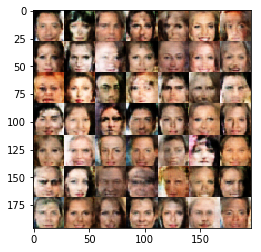

Epoch 1/1 Discriminator loss 1.1896 Generator loss 0.8737
Epoch 1/1 Discriminator loss 1.2646 Generator loss 0.7649
Epoch 1/1 Discriminator loss 1.3562 Generator loss 1.1158
Epoch 1/1 Discriminator loss 1.2587 Generator loss 0.9151
Epoch 1/1 Discriminator loss 1.3660 Generator loss 0.6007
Epoch 1/1 Discriminator loss 1.3860 Generator loss 0.6980
Epoch 1/1 Discriminator loss 1.3512 Generator loss 0.9392
Epoch 1/1 Discriminator loss 1.2146 Generator loss 1.0918
Epoch 1/1 Discriminator loss 1.2558 Generator loss 0.8401
Epoch 1/1 Discriminator loss 1.3027 Generator loss 0.9599
(?, 28, 28, 3)


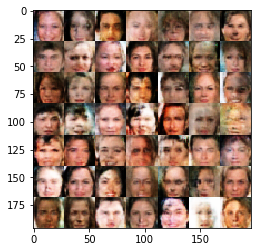

Epoch 1/1 Discriminator loss 1.4280 Generator loss 0.5057
Epoch 1/1 Discriminator loss 1.3544 Generator loss 0.5881
Epoch 1/1 Discriminator loss 1.3679 Generator loss 0.6842
Epoch 1/1 Discriminator loss 1.3671 Generator loss 0.5500
Epoch 1/1 Discriminator loss 1.4789 Generator loss 0.4970
Epoch 1/1 Discriminator loss 1.3595 Generator loss 0.5826
Epoch 1/1 Discriminator loss 1.2944 Generator loss 1.0203
Epoch 1/1 Discriminator loss 1.3500 Generator loss 0.6593
Epoch 1/1 Discriminator loss 1.1941 Generator loss 0.8123
Epoch 1/1 Discriminator loss 1.2956 Generator loss 0.9784
(?, 28, 28, 3)


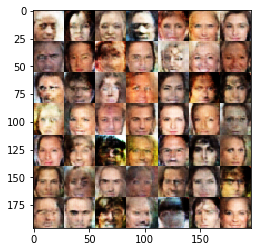

Epoch 1/1 Discriminator loss 1.4024 Generator loss 1.1665
Epoch 1/1 Discriminator loss 1.3863 Generator loss 0.7518
Epoch 1/1 Discriminator loss 1.1950 Generator loss 0.9340
Epoch 1/1 Discriminator loss 1.6647 Generator loss 0.3614
Epoch 1/1 Discriminator loss 1.2649 Generator loss 0.7648
Epoch 1/1 Discriminator loss 1.2798 Generator loss 0.8212
Epoch 1/1 Discriminator loss 1.3515 Generator loss 0.7893
Epoch 1/1 Discriminator loss 1.0547 Generator loss 1.1983
Epoch 1/1 Discriminator loss 1.3022 Generator loss 1.0197
Epoch 1/1 Discriminator loss 1.2832 Generator loss 1.0929
(?, 28, 28, 3)


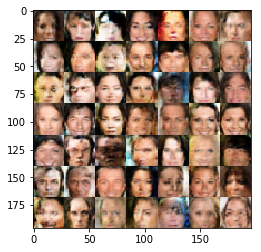

Epoch 1/1 Discriminator loss 1.3768 Generator loss 0.7578
Epoch 1/1 Discriminator loss 1.2177 Generator loss 0.8834
Epoch 1/1 Discriminator loss 1.4118 Generator loss 0.5154
Epoch 1/1 Discriminator loss 1.2732 Generator loss 0.6679
Epoch 1/1 Discriminator loss 1.2439 Generator loss 0.7144
Epoch 1/1 Discriminator loss 1.4738 Generator loss 0.4908
Epoch 1/1 Discriminator loss 1.1756 Generator loss 1.0962
Epoch 1/1 Discriminator loss 1.2562 Generator loss 0.7318
Epoch 1/1 Discriminator loss 1.3903 Generator loss 0.6187
Epoch 1/1 Discriminator loss 1.3083 Generator loss 0.8789
(?, 28, 28, 3)


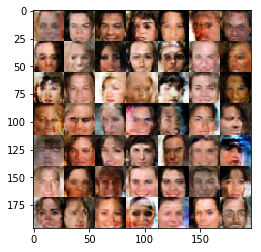

Epoch 1/1 Discriminator loss 1.2168 Generator loss 0.9771
Epoch 1/1 Discriminator loss 1.2760 Generator loss 0.7523
Epoch 1/1 Discriminator loss 1.4167 Generator loss 1.2803
Epoch 1/1 Discriminator loss 1.3157 Generator loss 0.9084
Epoch 1/1 Discriminator loss 1.4221 Generator loss 0.5601
Epoch 1/1 Discriminator loss 1.3505 Generator loss 0.6482
Epoch 1/1 Discriminator loss 1.3752 Generator loss 0.5545
Epoch 1/1 Discriminator loss 1.2767 Generator loss 0.7338
Epoch 1/1 Discriminator loss 1.3190 Generator loss 1.0972
Epoch 1/1 Discriminator loss 1.3203 Generator loss 0.6966
(?, 28, 28, 3)


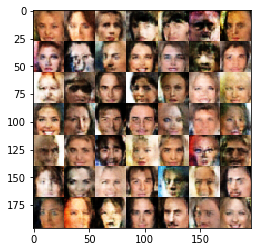

Epoch 1/1 Discriminator loss 1.3515 Generator loss 1.2083
Epoch 1/1 Discriminator loss 1.2640 Generator loss 0.8730
Epoch 1/1 Discriminator loss 1.2926 Generator loss 1.0146
Epoch 1/1 Discriminator loss 1.2845 Generator loss 0.9041
Epoch 1/1 Discriminator loss 1.2737 Generator loss 0.8655
Epoch 1/1 Discriminator loss 1.3283 Generator loss 0.7337
Epoch 1/1 Discriminator loss 1.4568 Generator loss 0.5553
Epoch 1/1 Discriminator loss 1.2994 Generator loss 0.8636
Epoch 1/1 Discriminator loss 1.2684 Generator loss 0.8967
Epoch 1/1 Discriminator loss 1.3378 Generator loss 1.1145
(?, 28, 28, 3)


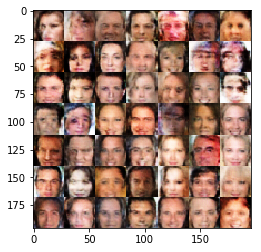

Epoch 1/1 Discriminator loss 1.2955 Generator loss 0.7978
Epoch 1/1 Discriminator loss 1.4225 Generator loss 1.0586
Epoch 1/1 Discriminator loss 1.3648 Generator loss 0.7923
Epoch 1/1 Discriminator loss 1.2896 Generator loss 0.9989
Epoch 1/1 Discriminator loss 1.2229 Generator loss 0.9136
Epoch 1/1 Discriminator loss 1.3104 Generator loss 1.0102
Epoch 1/1 Discriminator loss 1.3784 Generator loss 1.1559
Epoch 1/1 Discriminator loss 1.3235 Generator loss 0.9897
Epoch 1/1 Discriminator loss 1.4190 Generator loss 1.1228
Epoch 1/1 Discriminator loss 1.2027 Generator loss 0.8455
(?, 28, 28, 3)


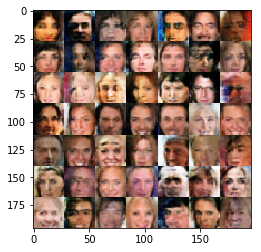

Epoch 1/1 Discriminator loss 1.2684 Generator loss 0.9110
Epoch 1/1 Discriminator loss 1.4123 Generator loss 0.5673
Epoch 1/1 Discriminator loss 1.3024 Generator loss 0.7688
Epoch 1/1 Discriminator loss 1.2637 Generator loss 0.6958
Epoch 1/1 Discriminator loss 1.2102 Generator loss 0.7233
Epoch 1/1 Discriminator loss 1.2896 Generator loss 0.9335
Epoch 1/1 Discriminator loss 1.5264 Generator loss 1.4457
Epoch 1/1 Discriminator loss 1.2160 Generator loss 0.9679
Epoch 1/1 Discriminator loss 1.2607 Generator loss 1.0171
Epoch 1/1 Discriminator loss 1.3710 Generator loss 1.1400
(?, 28, 28, 3)


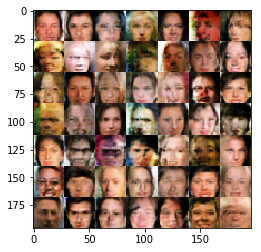

Epoch 1/1 Discriminator loss 1.3113 Generator loss 0.7877
Epoch 1/1 Discriminator loss 1.2483 Generator loss 0.9023
Epoch 1/1 Discriminator loss 1.3139 Generator loss 0.7334
Epoch 1/1 Discriminator loss 1.3429 Generator loss 0.7105
Epoch 1/1 Discriminator loss 1.2568 Generator loss 0.8772
Epoch 1/1 Discriminator loss 1.2361 Generator loss 0.9430
Epoch 1/1 Discriminator loss 1.2983 Generator loss 0.7155
Epoch 1/1 Discriminator loss 1.3140 Generator loss 0.7674
Epoch 1/1 Discriminator loss 1.3651 Generator loss 0.7378
Epoch 1/1 Discriminator loss 1.3351 Generator loss 0.7781
(?, 28, 28, 3)


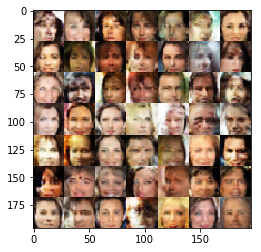

Epoch 1/1 Discriminator loss 1.4309 Generator loss 1.1342
Epoch 1/1 Discriminator loss 1.2201 Generator loss 0.9660
Epoch 1/1 Discriminator loss 1.2942 Generator loss 0.9475
Epoch 1/1 Discriminator loss 1.3267 Generator loss 0.8928
Epoch 1/1 Discriminator loss 1.3682 Generator loss 0.9367
Epoch 1/1 Discriminator loss 1.3174 Generator loss 1.1712
Epoch 1/1 Discriminator loss 1.3072 Generator loss 0.6663
Epoch 1/1 Discriminator loss 1.4398 Generator loss 1.2370
Epoch 1/1 Discriminator loss 1.2864 Generator loss 0.8039
Epoch 1/1 Discriminator loss 1.2554 Generator loss 0.7001
(?, 28, 28, 3)


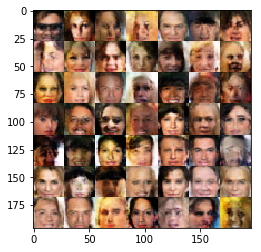

Epoch 1/1 Discriminator loss 1.3640 Generator loss 0.7180
Epoch 1/1 Discriminator loss 1.4016 Generator loss 0.9352
Epoch 1/1 Discriminator loss 1.2954 Generator loss 1.0974
Epoch 1/1 Discriminator loss 1.3855 Generator loss 1.1232
Epoch 1/1 Discriminator loss 1.3210 Generator loss 0.9796
Epoch 1/1 Discriminator loss 1.0841 Generator loss 1.0970
Epoch 1/1 Discriminator loss 1.2422 Generator loss 0.9728
Epoch 1/1 Discriminator loss 1.2647 Generator loss 0.8959
Epoch 1/1 Discriminator loss 1.3104 Generator loss 0.6461
Epoch 1/1 Discriminator loss 1.4200 Generator loss 0.5584
(?, 28, 28, 3)


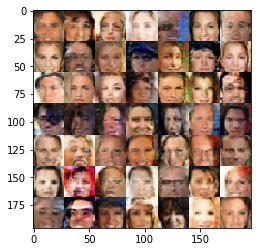

Epoch 1/1 Discriminator loss 1.2933 Generator loss 0.6352
Epoch 1/1 Discriminator loss 1.2613 Generator loss 0.8066
Epoch 1/1 Discriminator loss 1.2789 Generator loss 1.0308
Epoch 1/1 Discriminator loss 1.2548 Generator loss 0.8478
Epoch 1/1 Discriminator loss 1.3051 Generator loss 0.8903
Epoch 1/1 Discriminator loss 1.3571 Generator loss 1.0857
Epoch 1/1 Discriminator loss 1.3195 Generator loss 0.9860
Epoch 1/1 Discriminator loss 1.2024 Generator loss 1.0229
Epoch 1/1 Discriminator loss 1.3109 Generator loss 0.8193
Epoch 1/1 Discriminator loss 1.2644 Generator loss 1.1135
(?, 28, 28, 3)


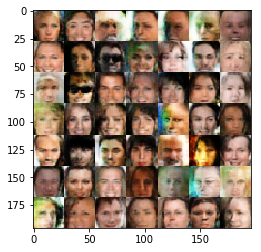

Epoch 1/1 Discriminator loss 1.2636 Generator loss 0.7901
Epoch 1/1 Discriminator loss 1.4127 Generator loss 0.5327
Epoch 1/1 Discriminator loss 1.3627 Generator loss 0.6077
Epoch 1/1 Discriminator loss 1.3954 Generator loss 0.6530
Epoch 1/1 Discriminator loss 1.3711 Generator loss 0.5848
Epoch 1/1 Discriminator loss 1.2609 Generator loss 0.6846
Epoch 1/1 Discriminator loss 1.3123 Generator loss 0.6095
Epoch 1/1 Discriminator loss 1.2713 Generator loss 0.6764
Epoch 1/1 Discriminator loss 1.4276 Generator loss 0.5424
Epoch 1/1 Discriminator loss 1.2933 Generator loss 0.6361
(?, 28, 28, 3)


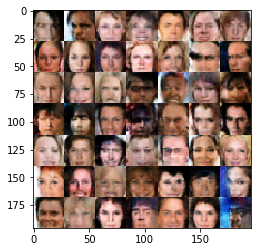

Epoch 1/1 Discriminator loss 1.3853 Generator loss 0.8051
Epoch 1/1 Discriminator loss 1.3201 Generator loss 1.1104
Epoch 1/1 Discriminator loss 1.5088 Generator loss 1.3417
Epoch 1/1 Discriminator loss 1.3095 Generator loss 0.7748
Epoch 1/1 Discriminator loss 1.2932 Generator loss 0.7530
Epoch 1/1 Discriminator loss 1.2661 Generator loss 0.9589
Epoch 1/1 Discriminator loss 1.2825 Generator loss 0.8785
Epoch 1/1 Discriminator loss 1.4623 Generator loss 1.3368
Epoch 1/1 Discriminator loss 1.2717 Generator loss 0.7366
Epoch 1/1 Discriminator loss 1.3353 Generator loss 0.7055
(?, 28, 28, 3)


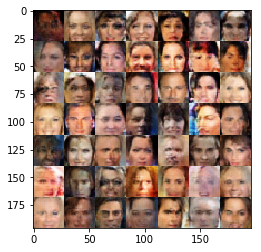

Epoch 1/1 Discriminator loss 1.2993 Generator loss 1.0328
Epoch 1/1 Discriminator loss 1.2460 Generator loss 0.8697
Epoch 1/1 Discriminator loss 1.3664 Generator loss 0.9372
Epoch 1/1 Discriminator loss 1.2756 Generator loss 0.9325
Epoch 1/1 Discriminator loss 1.3019 Generator loss 0.8295
Epoch 1/1 Discriminator loss 1.3591 Generator loss 1.0171
Epoch 1/1 Discriminator loss 1.3080 Generator loss 1.0970
Epoch 1/1 Discriminator loss 1.3165 Generator loss 0.7125
Epoch 1/1 Discriminator loss 1.3730 Generator loss 0.6839
Epoch 1/1 Discriminator loss 1.3294 Generator loss 0.5891
(?, 28, 28, 3)


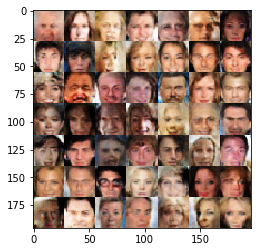

Epoch 1/1 Discriminator loss 1.2571 Generator loss 0.7185
Epoch 1/1 Discriminator loss 1.3741 Generator loss 0.6313
Epoch 1/1 Discriminator loss 1.3722 Generator loss 0.5256
Epoch 1/1 Discriminator loss 1.2925 Generator loss 0.7522
Epoch 1/1 Discriminator loss 1.3709 Generator loss 0.5467
Epoch 1/1 Discriminator loss 1.3363 Generator loss 0.5745
Epoch 1/1 Discriminator loss 1.2478 Generator loss 0.7950
Epoch 1/1 Discriminator loss 1.2359 Generator loss 1.0282
Epoch 1/1 Discriminator loss 1.3946 Generator loss 1.1339
Epoch 1/1 Discriminator loss 1.2574 Generator loss 0.8204
(?, 28, 28, 3)


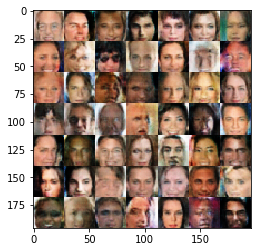

Epoch 1/1 Discriminator loss 1.2335 Generator loss 0.8410
Epoch 1/1 Discriminator loss 1.2799 Generator loss 0.8153
Epoch 1/1 Discriminator loss 1.1562 Generator loss 0.8079
Epoch 1/1 Discriminator loss 1.5094 Generator loss 1.2995
Epoch 1/1 Discriminator loss 1.3017 Generator loss 0.8691
Epoch 1/1 Discriminator loss 1.2428 Generator loss 0.8230


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.